# Homework 4. Decision Tree Classifier and Decision Tree Regressor

In [115]:
import matplotlib.pyplot as plt
import random
from collections import Counter
from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [116]:
classification_data, classification_labels = datasets.make_classification(
                                               n_features = 2, 
# количество признаков
                                               n_informative = 2, 
# Каждый класс информативного признака состоит из ряда гауссовских кластеров, 
# каждый расположен вокруг вершин гиперкуба в подпространстве измерения n_informative. 
# Для каждого кластера информативные признаки рисуются независимо от N (0, 1), 
# а затем случайным образом линейно комбинируются в каждом кластере для добавления ковариации. 
# Затем кластеры размещаются в вершинах гиперкуба.
                                               n_classes = 2, 
# количество меток или лейблов
                                               n_redundant=0, 
# Количество избыточных признаков. Эти признаки генерируются как случайные линейные комбинации 
# информативных признаков.
                                               n_clusters_per_class=1, 
                                               random_state=5
                                           )

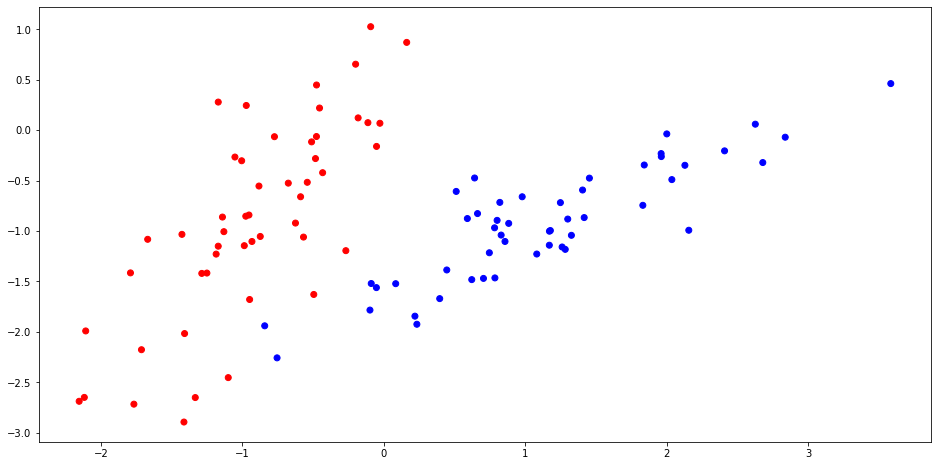

In [117]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(16,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [118]:
def mse(y_true, y_pred):
    return sum((y_true - y_pred)**2) / len(y_true)

In [119]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

### В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

In [120]:
class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле


class Leaf:

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        prediction = np.average(self.labels)
        return prediction


def variance(labels):
    return (1 / labels.shape[0]) * np.sum((labels - np.mean(labels)) ** 2)


def quality(left_labels, right_labels, current_variance):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_variance - p * variance(left_labels) - (1 - p) * variance(right_labels)


def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)

    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels


def find_best_split(data, labels):
    min_leaf = 5

    current_variance = variance(labels)

    best_quality = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]

    for index in range(n_features):
        t_values = np.unique(data[:, index])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_quality = quality(true_labels, false_labels, current_variance)

            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


def build_tree(data, labels, curr_depth=0, min_gain=None, max_depth=3):
    if (max_depth is not None) and (curr_depth == max_depth):
        return Leaf(data, labels)

    quality, t, index = find_best_split(data, labels)

    if (quality == 0) or ((min_gain is not None) and quality < min_gain):
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    true_branch = build_tree(true_data, true_labels, curr_depth + 1)
    false_branch = build_tree(false_data, false_labels, curr_depth + 1)

    return Node(index, t, true_branch, false_branch)


def classify_object(obj, node):
    if isinstance(node, Leaf):
        return node.prediction

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)


def predict(data, tree):
    return np.array([classify_object(obj, tree) for obj in data])

In [138]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
                                                       classification_data, 
                                                       classification_labels, 
                                                       test_size = 0.3,
                                                       random_state = 1
                                                   )

In [139]:
# import pandas as pd
# import numpy as np
# from scipy.stats import mode
# df = pd.read_csv('../datasets/framingham.csv')
# df = df.sample(frac=0.5)
# df

In [140]:
# # X = df[['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'glucose', 'heartRate']]
# X = df[['heartRate', 'BMI']]
# y = df[['cigsPerDay']]
# values = {
# #     'education': float(X.education.mode()), 
# #          'cigsPerDay': float(X.cigsPerDay.mode()),
# #          'glucose': float(X.glucose.mode()),
#          'BMI': float(X.BMI.mean()), 
#          'heartRate': float(X.heartRate.mode())}
# X = X.fillna(values)
# y = y.fillna(0)

In [141]:
# def calc_std_feat(x):
#     res = (x - x.mean()) / x.std()
#     return res
# X_st = X.copy()
# cols = ['heartRate', 'BMI']
# for col in cols:
#     X_st[col] = calc_std_feat(X_st[col])

# X_st.T.values.shape

In [142]:
classification_data, classification_labels = train_data, train_labels

In [143]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X_st, y, test_size = 0.4,random_state=42) 
# train_data, test_data, train_labels, test_labels = \
# X_train.values, X_test.values, y_train.T.values[0], y_test.T.values[0]     

In [144]:
my_tree = build_tree(train_data, train_labels, max_depth=5)

In [145]:
def print_tree(node, spacing=""):

    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.9402933258134305
  --> True:
    Прогноз: 0.2
  --> False:
    Прогноз: 0.0
--> False:
  Прогноз: 1.0


In [146]:
train_answers = predict(train_data, my_tree)

In [147]:
answers = predict(test_data, my_tree)

In [148]:
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

89.79591836734694

In [149]:
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

76.19047619047619

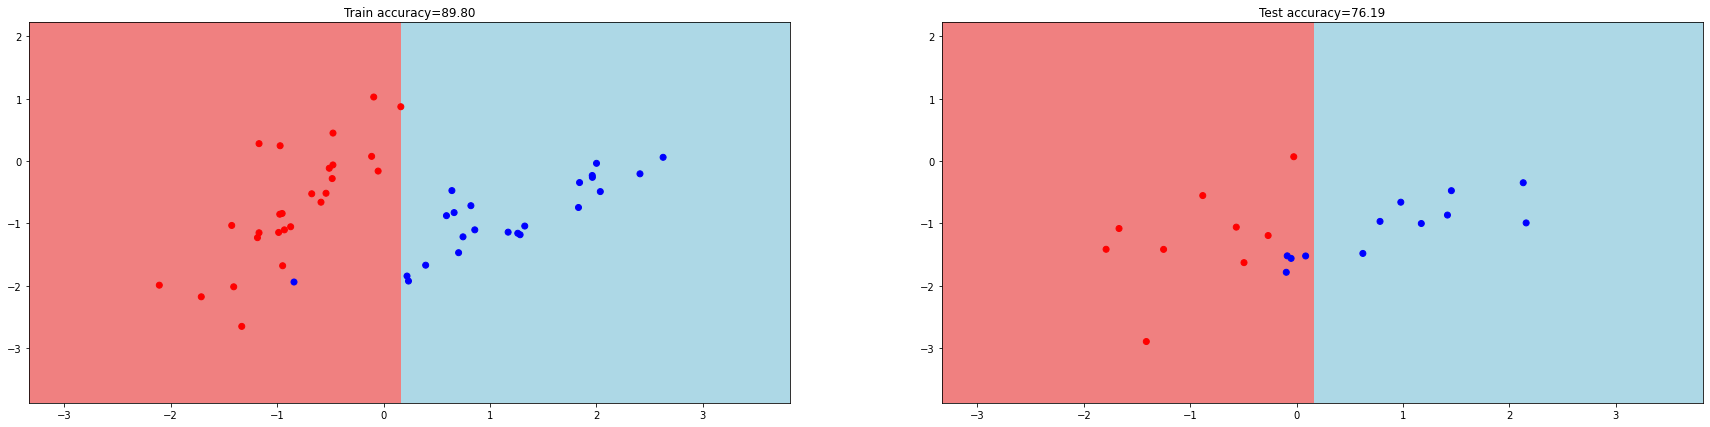

In [150]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
#     print(f'x_min: {x_min}\tx_max: {x_max}\n data[:, 0].min() - border: {data[:, 0]}, {data[:, 0].min()}, {border}')
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
#     print()
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (30, 7))

plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
# xx.shape # (201, 161)
# yy.shape # (201, 161)
# xx.ravel() # (32361,)
# yy.ravel().shape # (32361,)
# predict(np.c_[xx.ravel(), yy.ravel()], tree=my_tree).reshape(xx.shape)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
# mesh_predictions = np.array(predict(np.c_[xx.reshape(-1), yy.reshape(-1)], my_tree)).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}');

plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}');

<p style='background-color: #fa9; color: #000; padding: 10px; border: 0.5px solid #000; font-size: 19px'>Созданная модель дерева решений очень плохо работает на данном датасете - видно, что риск получить порок сердца через 10 лет коррелирует с уровнем глюкозы, количеством скуренных в день сигарет или частотой сердечных сокращений не так хорошо, как хотелось бы и выставление различных параметров (максимальная глубина, минимальное количество листьев, ограничение по качеству) не влияет на результат. </p>

### * Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [151]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        prediction = np.average(self.labels)
        return prediction        
    
def variance(labels):
    return (1 / labels.shape[0]) * np.sum((labels - np.mean(labels))**2)

def quality(left_labels, right_labels, current_variance):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_variance - p * variance(left_labels) - (1 - p) * variance(right_labels)

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

def find_best_split(data, labels):
    
    min_leaf = 3
    
    current_variance = variance(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_variance)
            
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

def build_tree(data, labels, curr_depth=0, min_gain=None, max_depth=3):
    if (max_depth is not None) and (curr_depth == max_depth):
        return Leaf(data, labels)
    
    quality, t, index = find_best_split(data, labels)

    if (quality == 0) or ((min_gain is not None) and quality < min_gain):
        return Leaf(data, labels)
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    true_branch = build_tree(true_data, true_labels, curr_depth + 1)
    false_branch = build_tree(false_data, false_labels, curr_depth + 1)

    return Node(index, t, true_branch, false_branch)

def classify_object(obj, node):

    if isinstance(node, Leaf): return node.prediction

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

def predict(data, tree):
    return np.array([classify_object(obj, tree) for obj in data])

In [36]:
X_reg, y_reg = datasets.make_regression(n_features = 2, n_informative = 2, n_targets = 1, random_state=5)
reg_tree = build_tree(X_reg, y_reg, max_depth=5, min_gain=0.1)


def print_tree(node, spacing=""):
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    print(spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    print(spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

print_tree(reg_tree)

Индекс 0
Порог 0.03654264148725312
--> True:
  Индекс 0
  Порог -0.689565232048181
  --> True:
    Индекс 0
    Порог -1.167278449710173
    --> True:
      Прогноз: -121.39064849773837
    --> False:
      Прогноз: -59.70469676988845
  --> False:
    Индекс 1
    Порог -0.3058530211666308
    --> True:
      Прогноз: -34.88181961830964
    --> False:
      Прогноз: -5.432729259680711
--> False:
  Индекс 0
  Порог 0.9721793096791724
  --> True:
    Индекс 1
    Порог 0.6566194702604272
    --> True:
      Прогноз: 21.78115867200141
    --> False:
      Прогноз: 55.22855841895343
  --> False:
    Индекс 0
    Порог 1.5824811170615634
    --> True:
      Прогноз: 88.2380476495344
    --> False:
      Прогноз: 139.425963489852


In [37]:
pred = predict(X_reg, reg_tree)

In [38]:
accuracy_metric(y_reg, pred)

0.0

In [39]:
mse(y_reg, pred)

266.94469998237963